In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from numpy import random

from ipywidgets import *
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [2]:
def plot_hrly_avgs(sliders, label, color):
    ind = np.arange(24)  
    width = 0.75  

    fig, ax = plt.subplots(1, figsize=(12, 5))
    rects1 = ax.bar(ind, [i.value for i in sliders], width, label=label, color=color)

    ax.set_ylabel('avg # of patients')
    ax.set_xlabel('hour of day')

    ax.set_xticks(ind)
    ax.legend()
    plt.show()

def hrly_avg_change(b):
    output1.clear_output()
    with output1:
        plot_hrly_avgs(avg_pl_hrly_sliders, "Planned", "b")
    
    output2.clear_output()
    with output2:
        plot_hrly_avgs(avg_upl_hrly_sliders, "Unplanned", "r")

In [3]:
avg_plan_hrly = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 1.5, 2.0, 2.1, 2.2, 2.2, 3.2, 3.1, 2.1, 2.1, 2.0, 1.5, 1.4, 1.1, 1.0, 1.0, 
                             0.2, 0.2, 0.2, 0.2])

avg_pl_hrly_sliders = [FloatSlider(value=n, min=0.0, max=20.0, step=0.25,  description=str(h), continuous_update=False, 
                                   orientation="vertical", layout=Layout(width="110%")) for n,h in zip(avg_plan_hrly, np.arange(0,24, 1))]

avg_unplan_hrly = np.array([3.5, 3.1 ,2.9, 2.8, 2.64, 2.45, 2.4, 4.5, 5.9, 6.7, 6.5, 5.4, 5.6, 5.8, 5.7, 5.6, 5.3, 5.2, 5.3, 6,
                         6.5, 5.2, 4.3, 3.9])

avg_upl_hrly_sliders = [FloatSlider(value=n, min=0.0, max=30.0, step=0.25,  description=str(h), continuous_update=False, 
                                    orientation="vertical", layout=Layout(width="100%")) for n,h in zip(avg_unplan_hrly, np.arange(0,24, 1))]

In [4]:
output1 = Output(wait=True)
output2 = Output()

output1.layout.height = '350px'
output2.layout.height = '350px'

_ = [i.observe(hrly_avg_change, names=['value']) for i in avg_pl_hrly_sliders]
_ = [i.observe(hrly_avg_change, names=['value']) for i in avg_upl_hrly_sliders]

In [5]:
center_layout = Layout(align_items="center", justify_content='center')

In [6]:
tabs = [VBox([output1, HBox(avg_pl_hrly_sliders)], layout=center_layout), 
      VBox([output2, HBox(avg_upl_hrly_sliders)], layout=center_layout)]

plt_tab = Tab()
plt_tab.children = tabs
plt_tab.set_title(0, 'Planned Adm Hrly')
plt_tab.set_title(1, 'Unplanned Adm Hrly')

In [7]:

sidebar1 = VBox([HTML(value="<H3>Admission Statistics:</H3>"), HTML(value="<p>Set hourly averages for gross planned and unplanned admissions </p>")])

In [8]:
AppLayout(left_sidebar=sidebar1,
          center=plt_tab)

AppLayout(children=(VBox(children=(HTML(value='<H3>Admission Statistics:</H3>'), HTML(value='<p>Set hourly ave…

In [9]:
hrly_avg_change(None)

In [10]:
def p_los_gen(x):
    times = []
    for i in range(x['Unplanned']):
        times.append(x['Datetime'] + pd.Timedelta(value=abs(round(random.normal(loc=pl_los_avg.value, scale=pl_los_std.value))), unit='hours' ))
    return times
    
def up_los_gen(x):
    times = []
    for i in range(x['Planned']):
        times.append(x['Datetime'] + pd.Timedelta(value=abs(round(random.normal(loc=unpl_los_avg.value, scale=unpl_los_std.value))), unit='hours' ))
    return times 

def gen_los(df):
    
    df_los = df[['Datetime','Discharge Time']].explode('Discharge Time').dropna().reset_index(drop=True)
    
    dis = []
    
    for time in df['Datetime']:
        dis.append(len(df_los['Discharge Time'][df_los['Discharge Time'] == time].tolist()))
        
    df['Discharge'] = dis
    
    return df

In [11]:
def count_days(start, end):
    if start.value and end.value:
        delta = end.value - start.value
        return delta.days

def gen_adm_df(avg_p_sliders, avg_up_sliders, start_wid, end_wid, back=21):

    num_days = count_days(start_wid, end_wid)
    backdate = start.value - datetime.timedelta(days=back)
    datetime_index = [pd.Timestamp((backdate + datetime.timedelta(days=day)).strftime("%Y-%m-%d") + f' {hr}:00:00') for day in range(num_days+back) for hr in range(24)]

    df = pd.DataFrame(columns=["ED Volume", "Unplanned", "Planned"], index=datetime_index)

    df['Planned'] = [(random.poisson(p.value)) for days in range(num_days+21) for p in avg_p_sliders]
    df['ED Volume'] = [round(random.poisson(up.value)) for days in range(num_days+21) for up in avg_up_sliders]
    df['Unplanned'] = round(df['ED Volume'] * unplan_adm_rate.value).astype(int)
    df['Admit'] = df['Planned'] + df['Unplanned']
    df['Datetime'] = df.index
    df['Discharge Time'] = df.apply(p_los_gen, axis=1) + df.apply(up_los_gen, axis=1)
    
    df = gen_los(df)
    
    df['Occupied'] = df['Admit'].cumsum() - df['Discharge'].cumsum()
    
    return df

In [12]:
#### Dates selectors ####
today = datetime.date.today()

start = DatePicker( description='Begin:', disabled=False)
start.value = today - datetime.timedelta(days=7)

end = DatePicker(description='End:', disabled=False)
end.value = today

unplan_adm_rate = FloatSlider(value=0.3, min=0.0, max=1.0, step=0.05, description='(%)', continuous_update=False)

In [13]:
#### Sliders #### 

num_beds = IntSlider(value=250, min=100, max=500, description='Beds',  continuous_update=False)

pl_los_avg = FloatSlider(value=72.0, min=0.0, max=240.0, step=1.0,  description='avg', continuous_update=False)
pl_los_std = FloatSlider(value=36.0, min=0.0, max=100.0, step=1.0,  description='std', continuous_update=False)

unpl_los_avg = FloatSlider(value=48.0, min=0.0, max=120.0, step=1.0,  description='avg', continuous_update=False)
unpl_los_std = FloatSlider(value=24.0, min=0.0, max=60.0, step=1.0,  description='std', continuous_update=False)

In [14]:
def autolabel(ax, rects, xpos='center'):
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

In [15]:
def plot_adms(df):
    df = df[(df['Datetime'] > pd.Timestamp(start.value))]
    ind = np.arange(df['Datetime'].dt.day.nunique())
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(ind - width/2, df['Planned'].resample('D').sum().tolist(), width, label='Planned', color='b')
    rects2 = ax.bar(ind + width/2, df['Unplanned'].resample('D').sum().tolist(), width, label='Unplanned', color='r')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('# of patients')
    ax.set_title('Admissions Per Day')
    ax.set_xticks(ind)
    ax.set_xticklabels(np.unique(df['Datetime'].dt.date))
    fig.autofmt_xdate()
    ax.legend()

    autolabel(ax, rects1, "left")
    autolabel(ax, rects2, "right")
 
    plt.show()

In [16]:
def plot_ed_vol(df):
    df = df[(df['Datetime'] > pd.Timestamp(start.value))]

    fig, ax = plt.subplots(figsize=(12, 7))
    bars = ax.bar(df['Datetime'], df['ED Volume'], label='ED Volume',  align='center', width=0.02)
    
    for bar in bars:
        bar.set_edgecolor("black")
        bar.set_linewidth(1)


    ax.set_ylabel('# of patients')
    ax.set_title('ED Volume by hour')
#     ax.set_xticks(ind)
#     ax.set_xticklabels(np.unique(df.index.date))
    fig.autofmt_xdate()
    ax.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_beds(df):
    df = df[(df['Datetime'] > pd.Timestamp(start.value))]
    max_beds = float(num_beds.value)
    fig, ax = plt.subplots(1, figsize=(12,7))
    ax.plot(df['Datetime'], df['Occupied'])
    plt.axhline(y=max_beds, color='r', linestyle='-')
    ax.set_ylabel('# of patients')
    ax.fill_between(df['Datetime'], df['Occupied'], max_beds, where= df['Occupied'] >= max_beds, alpha=0.50,  facecolor='r', edgecolor='r', interpolate=True)
    set_max = df['Occupied'].max() if df['Occupied'].max() > max_beds else max_beds + 10
    ax.set_ylim(df['Occupied'].min()-20, set_max)
    fig.autofmt_xdate()
    ax.legend(['Total Beds Occupied', "Max Bed Capacity"])
    plt.grid(True)
    plt.show();
   

In [18]:
def plot_beds_util(df):
    df = df[(df['Datetime'] > pd.Timestamp(start.value))]
    max_beds = float(num_beds.value)
    fig, ax = plt.subplots(1, figsize=(12,7))
    percents = (df['Occupied']/max_beds)*100
    ax.plot(df['Datetime'], percents)
    plt.axhline(y=100, color='r', linestyle='-')
    ax.set_ylabel('% of occupied beds')
    ax.set_ylim(0.0, 150)
    ax.fill_between(df['Datetime'], percents, max_beds, where= percents >= max_beds, alpha=0.50,  facecolor='r', edgecolor='r', interpolate=True)
    fig.autofmt_xdate()
    ax.legend(["% of Bed Utilization"])
    plt.grid(True)
    plt.show();
   

In [55]:
def plot_moving_avg(df, col, window=12):
    df = df[pd.Timestamp(start.value):]
    roll = df[col].rolling(window, win_type='gaussian').sum(std=3)
    
    fig, ax = plt.subplots(1, figsize=(12,7))
    ax.plot(df['Datetime'], roll)

#     ax.set_ylabel('Rolling Avg')
    fig.autofmt_xdate()
    ax.legend([f"{col} Rolling Mean"])
    plt.grid(True)
    plt.show();

In [19]:
hrs_back = IntSlider(value=90, min=0.0, max=180.0, step=1, description='Hours', continuous_update=False)

In [20]:
def bed_matrix(df, hours_back=90):

    back = []

    for hour in range(hours_back, len(df)):
        p = df['Occupied'].iloc[hour-hours_back:hour] - df['Discharge'].iloc[hour-hours_back:hour]

        if not p.empty:
            back.append(p.reindex(index=p.index[::-1]))
            
    bc_df = pd.DataFrame(data = np.hstack([s.values.reshape(-1, 1) for s in back]), columns = [s.index[0] for s in back])
    
    return bc_df

In [56]:
def on_change(b):
    df = gen_adm_df(avg_pl_hrly_sliders, avg_upl_hrly_sliders, start, end)
    
    output3.clear_output()
    with output3:
        plot_adms(df)
    
    output4.clear_output()
    with output4:
        plot_ed_vol(df)
    
    output5.clear_output()
    with output5:
        plot_beds(df)
    
    output6.clear_output()
    with output6:
        plot_beds_util(df)
    
    output7.clear_output()
    with output7:
        bc_df = bed_matrix(df, hours_back=hrs_back.value)
        display(bc_df.loc[:, pd.Timestamp(start.value):])
    
    output8.clear_output()
    with output8:
        plot_moving_avg(df, 'Planned', 12)
        
    output9.clear_output()
    with output9:
        plot_moving_avg(df, 'Unplanned', 12)

In [24]:
gen_button = Button(description="Generate Data")

output3 = Output()
output4 = Output()
output5 = Output()
output6 = Output()
output7 = Output()
output8 = Output()
output9 = Output()


output3.layout.height = '450px'
output4.layout.height = '450px'
output5.layout.height = '450px'
output6.layout.height = '450px'
output7.layout.height = '450px'
output8.layout.height = '450px'

gen_button.on_click(on_change)
start.observe(on_change, names=['value'])
end.observe(on_change, names=['value'])
unplan_adm_rate.observe(on_change, names=['value'])
hrs_back.observe(on_change, names=['value'])

num_beds.observe(on_change, names=['value'])
unpl_los_avg.observe(on_change, names=['value'])
unpl_los_std.observe(on_change, names=['value'])
pl_los_avg.observe(on_change, names=['value'])
pl_los_std.observe(on_change, names=['value'])
hrs_back.observe(on_change, names=['value'])

In [25]:
tabs2 = [HBox([output3], layout=center_layout), HBox([output4], layout=center_layout),  HBox([output8], layout=center_layout),
        HBox([output9], layout=center_layout)]
tab2 = Tab()
tab2.children = tabs2
tab2.set_title(0, 'Admissions Per Day')
tab2.set_title(1, 'ED Volume')
tab2.set_title(2, 'Plan. Roll Mean')
tab2.set_title(3, 'Unplan. Roll Mean')

In [26]:
sidebar2 = VBox([HTML(value="<b>Unplanned Admission Rate:</b>"), unplan_adm_rate ])

dates = VBox([HTML(value="<H3>Generate Admission Data:</H3>"), 
              HBox([start, end], layout=Layout(justify_content='center', align_items='center'))])
footer = HBox([gen_button], layout=center_layout)

In [27]:
AppLayout(header=dates,
          left_sidebar=sidebar2,
          center=tab2,
          footer=footer)

AppLayout(children=(VBox(children=(HTML(value='<H3>Generate Admission Data:</H3>'), HBox(children=(DatePicker(…

In [28]:
tabs3 = [HBox([output5], layout=center_layout), HBox([output6], layout=center_layout)]
tab3 = Tab()
tab3.children = tabs3
tab3.set_title(0, 'Occupied Beds')
tab3.set_title(1, 'Bed Utilization')

In [29]:
los_sidebar = VBox([HTML(value="<H3>Bed Capacity Calculations:</H3>"),
                    HTML(value="<b>Total Beds:</b>"), num_beds,
                    HTML(value="<b>Planned LOS:</b>"), pl_los_avg, pl_los_std, 
                    HTML(value="<b>Unplanned LOS:</b>"), unpl_los_avg, unpl_los_std])

In [30]:
AppLayout(left_sidebar=los_sidebar, 
         center=tab3)

AppLayout(children=(VBox(children=(HTML(value='<H3>Bed Capacity Calculations:</H3>'), HTML(value='<b>Total Bed…

In [31]:
on_change(None)

In [32]:
HTML(value="<H3>Bed Capacity Matrix:</H3>")

HTML(value='<H3>Bed Capacity Matrix:</H3>')

In [33]:
display(HTML(value="<b>Hours Back:</b>"), hrs_back, output7)

HTML(value='<b>Hours Back:</b>')

IntSlider(value=90, continuous_update=False, description='Hours', max=180)

Output(layout=Layout(height='450px'))

In [34]:
HTML(value="<H3>Room Cycle:</H3>")

HTML(value='<H3>Room Cycle:</H3>')

In [35]:
HTML(value="<H3>Administrator Playground:</H3>")

HTML(value='<H3>Administrator Playground:</H3>')

In [36]:
HTML(value="<H3>Forecasting:</H3>")

HTML(value='<H3>Forecasting:</H3>')

In [37]:
df = gen_adm_df(avg_pl_hrly_sliders, avg_upl_hrly_sliders, start, end)
bc_df = bed_matrix(df)


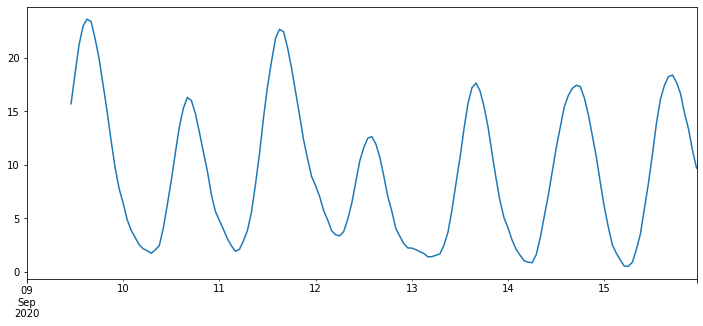